# Gaussian Processes

This notebook contains some exploratory examples of gaussian processes. The eventual goal (not for this notebook) is to build up to a bayesian functional optimization framework that can be used to find an optimum $\Delta x_e(z)$ which maximizes the likelihood for various values of $H_0$. 

In [4]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl 

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
mpl.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams['text.usetex']=True
fsize=16

In [5]:
def rbf_kernel(var, length):
    def k(t1, t2):
        exponent = -scipy.spatial.distance.cdist(t1, t2, 'sqeuclidean')/(2*length**2)
        return var**2*np.exp(exponent)
    return k

def linear_kernel(sig, sig_b, c):
    def k(t1, t2):
        return sig_b**2 + sig**2*(t1-c)*(t2-c)
    return k

def mult_kernels(k1, k2):
    def k(t1, t2):
        return k1(t1, t2)*k2(t1, t2)
    return k

def create_cov(k, points):
    X = np.expand_dims(points, 1)
    return k(X, X)

# X are test points, Y are training points
#np.einsum("iXl,lXY,jYl->ij", dCl, sigma_inv, dCl)
def condition(k, X, Y):
    print(len(X))
    xvalues = Y[:,0]
    yvalues = Y[:,1]
    mat = create_cov(k, np.hstack([X, xvalues]))
    sig_XX = mat[:len(X), :len(X)]
    sig_YY = mat[len(X):, len(X):]
    sig_XY = mat[:len(X), len(X):]
    sig_YX = sig_XY.T
    print(sig_XY.shape)
    mean = np.einsum("ij,jk,k->i", sig_XY, np.linalg.inv(sig_YY), yvalues)
    cov = sig_XX - np.einsum("ij,jk,kl->il", sig_XY, np.linalg.inv(sig_YY), sig_YX)

    return mean,cov


In [57]:
N=50
xlim = (-2, 2)
test_points = np.linspace(*xlim, N)
kernel = rbf_kernel(1, .7)
covmat = create_cov(k=kernel, points = test_points)
function_samples = []

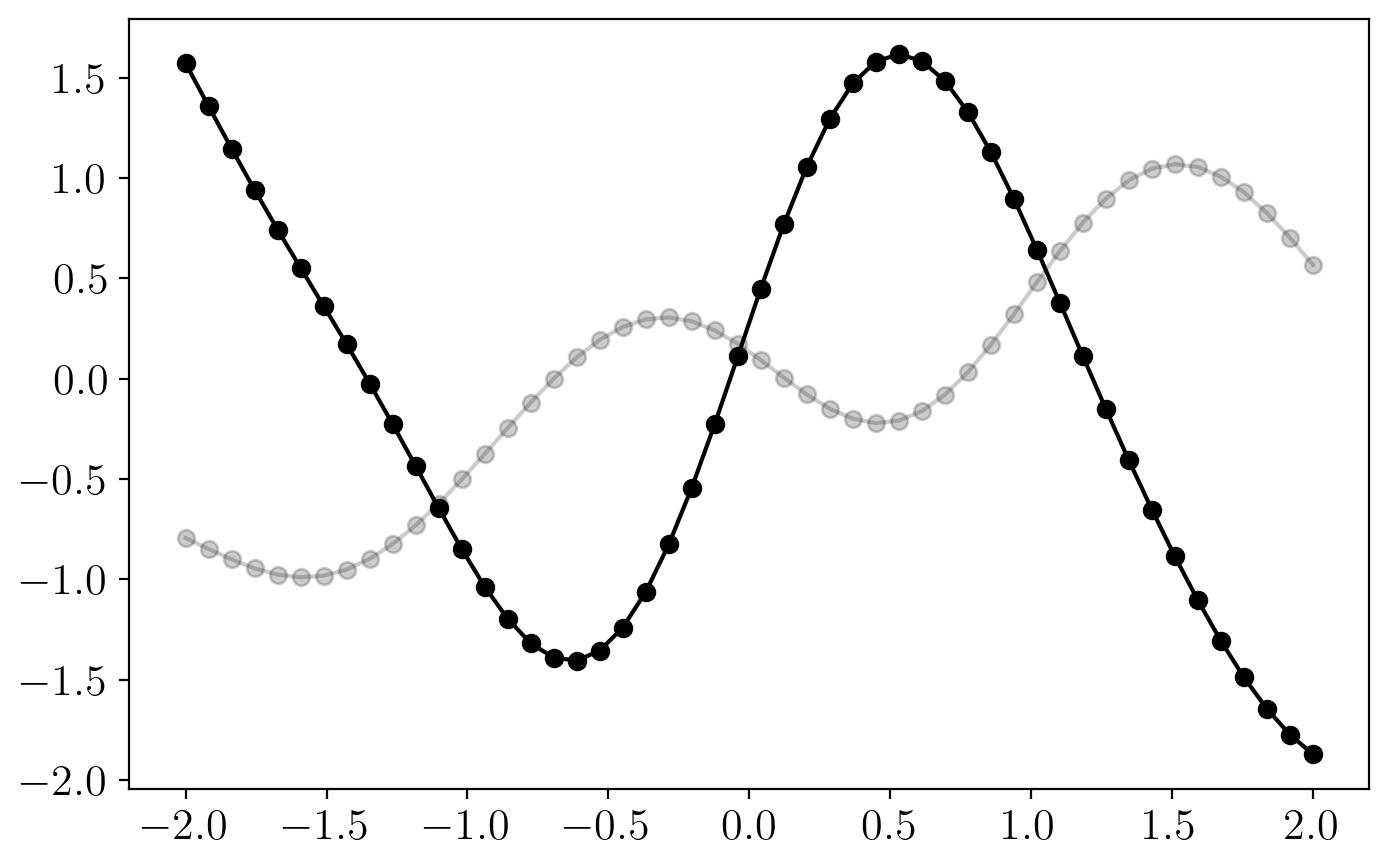

In [59]:
fig, ax = plt.subplots(figsize=(8,5))
function_samples.append(np.random.multivariate_normal(mean=np.zeros(N), cov=covmat))

for i,sample in enumerate(function_samples):
    if i==len(function_samples)-1:
        a=1.0
    else:
        a=0.2
    ax.plot(test_points, sample, linestyle="-", marker="o", color="black", alpha=a)

plt.show()

Here we condition on the training points, i.e. we generate a new covariance matrix for the test points $X$ given the values at the points $Y$.

In [60]:
training_points = np.array([[-2, 0], [2, 0]])
mu, sig = condition(kernel, test_points, training_points)

function_samples = []

print(sig)

mu_reduced = mu
sig_reduced = sig

50
(50, 2)
[[ 0.00000000e+00 -1.11022302e-16  0.00000000e+00 ... -5.29395592e-23
  -2.64697796e-23 -1.32348898e-23]
 [-1.11022302e-16  1.35077165e-02  2.66511322e-02 ...  1.91944745e-07
   6.77518678e-08 -2.64697796e-23]
 [ 0.00000000e+00  2.66511322e-02  5.29459405e-02 ...  5.40643591e-07
   1.91944745e-07 -5.29395592e-23]
 ...
 [-5.29395592e-23  1.91944745e-07  5.40643591e-07 ...  5.29459405e-02
   2.66511322e-02  0.00000000e+00]
 [-2.64697796e-23  6.77518678e-08  1.91944745e-07 ...  2.66511322e-02
   1.35077165e-02 -1.11022302e-16]
 [-1.32348898e-23 -2.64697796e-23 -5.29395592e-23 ...  0.00000000e+00
  -1.11022302e-16  0.00000000e+00]]


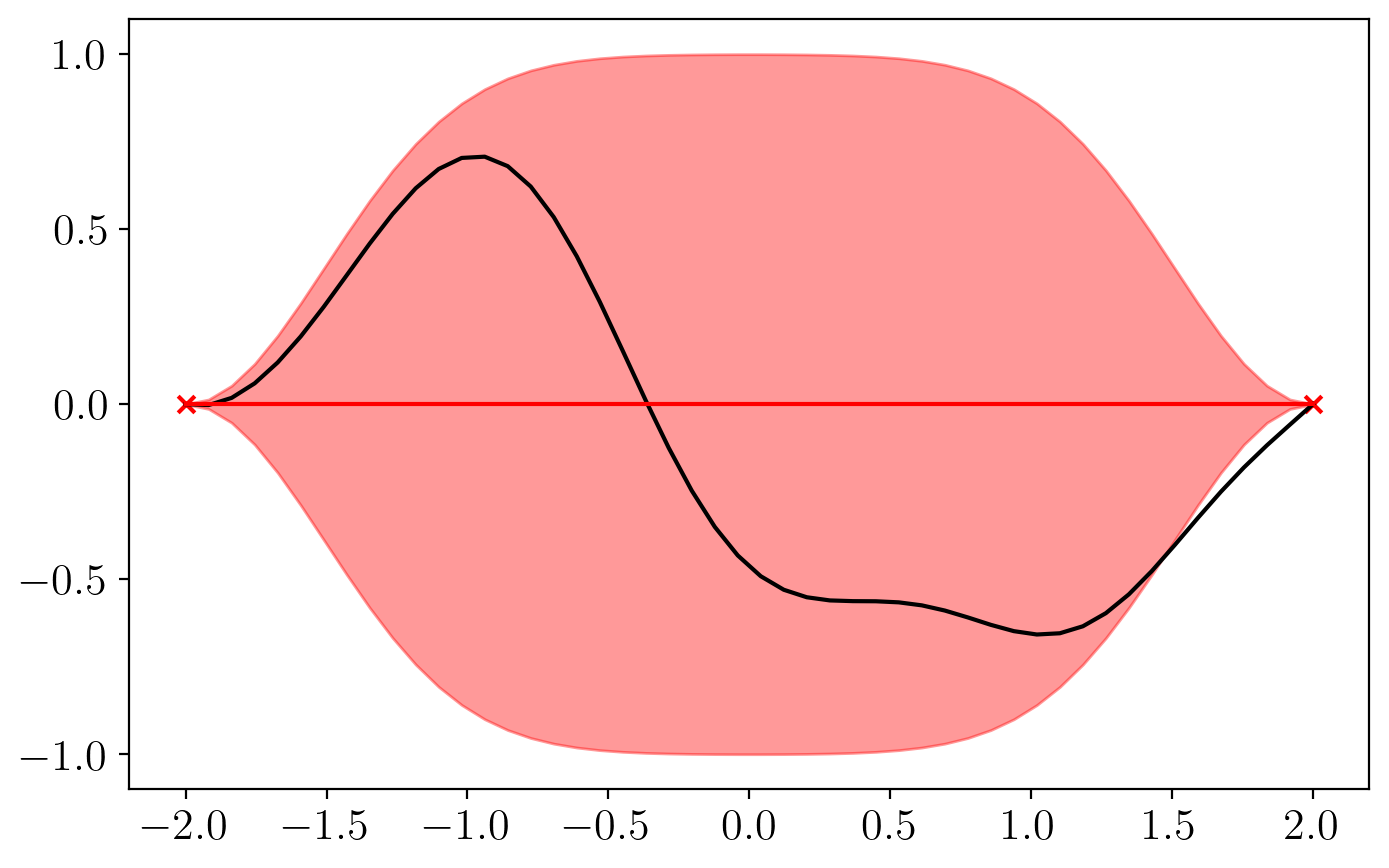

In [61]:
fig, ax = plt.subplots(figsize=(8,5))
function_samples.append(np.random.multivariate_normal(mean=mu_reduced, cov=sig_reduced))

upper_bound = mu_reduced+np.diag(sig_reduced)
lower_bound = mu_reduced-np.diag(sig_reduced)

for i,sample in enumerate(function_samples):
    if i==len(function_samples)-1:
        a=1.0
    else:
        a=0.2
    ax.plot(test_points, sample, linestyle="-", color="black", alpha=a)
ax.plot(test_points, mu, color="red")
ax.scatter(training_points[:,0], training_points[:,1], marker="x", color="red")
ax.fill_between(test_points, lower_bound, upper_bound, color="red", alpha=0.4)
plt.show()

## Cosmology digression
Here we digress to apply the above to generating $\Delta x_e(z)$.

In [15]:
import classy as Class
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

ln10e10As = 3.047
As = np.exp(ln10e10As)/(10**10)
print(As)

standard_params = {
    "omega_b": 0.02242,
    "omega_cdm": 0.11933,
    "n_s": 0.9665,
    "tau_reio": 0.0561,
    "ln10^{10}A_s": ln10e10As,
    "H0": 67.66
}

common_settings = {'output' : 'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'H0':standard_params["H0"],
                   'omega_b':standard_params["omega_b"],
                   'omega_cdm':standard_params["omega_cdm"],
                   'ln10^{10}A_s': standard_params["ln10^{10}A_s"],
                   'n_s':standard_params["n_s"],
                   'tau_reio': standard_params["tau_reio"],
                   'thermodynamics_verbose': 0,
                   'input_verbose': 1,
                   'lensing': 'yes',
                   'xe_pert_type': 'none'
                  }
precision_settings = {"start_sources_at_tau_c_over_tau_h": 0.004}

M = Class.Class()
M.set(common_settings)
M.set(precision_settings)

M.compute()

fiducial_thermo = M.get_thermodynamics()
Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin
ll_max = 2500
ll = np.arange(2, ll_max+1)
muK2 = (Tcmb)**2
tt_fid = muK2*M.lensed_cl(ll_max)['tt'][2:]

fiducial = fiducial_thermo["x_fid"]
fiducial_viz = fiducial_thermo["kappa' [Mpc^-1]"]*fiducial_thermo["exp(-kappa)"]
######################################################
######################################################
x_e = interp1d(fiducial_thermo["z"], fiducial_thermo["x_e"])
Yp = M.get_current_derived_parameters(['YHe'])['YHe']
xe_max = 1 + Yp/2*(1-Yp)

zmin_pert = 650
zmax_pert = 1400
zgrid = np.linspace(zmin_pert, zmax_pert, 200)
#zgrid = [zmin_pert, 1500, zmax_pert]

@np.vectorize
def rescale_pert_amp(amp, zz):
    shift = fsolve(lambda aa: scipy.special.expit(aa)*xe_max - x_e(zz), 0)
    return scipy.special.expit(amp+shift)*xe_max - x_e(zz)


2.105209331337507e-09
Reading input parameters
 -> matched budget equations by adjusting Omega_Lambda = 0.690267


In [41]:
N=20
xlim = (zmin_pert, zmax_pert)
test_points = np.linspace(*xlim, N)
kernel = rbf_kernel(4, 100)
covmat = create_cov(k=kernel, points = test_points)
training_points = np.array([[zmin_pert, 0], [zmax_pert,0]])
mu, sig = condition(kernel, test_points, training_points)
function_samples = []

for _ in np.arange(30):
    function_samples.append(np.random.multivariate_normal(mean=mu, cov=sig))

20
(20, 2)


[ 0.         -1.85366923 -3.25040732 -3.22065134 -2.194258   -1.35454982
 -1.34678885 -1.74844039 -1.63283519 -0.67980203  0.32045244  0.41778921
 -0.30007575 -1.04817839 -1.39181123 -1.26266492 -0.57962721  0.39889192
  0.82198434  0.        ]


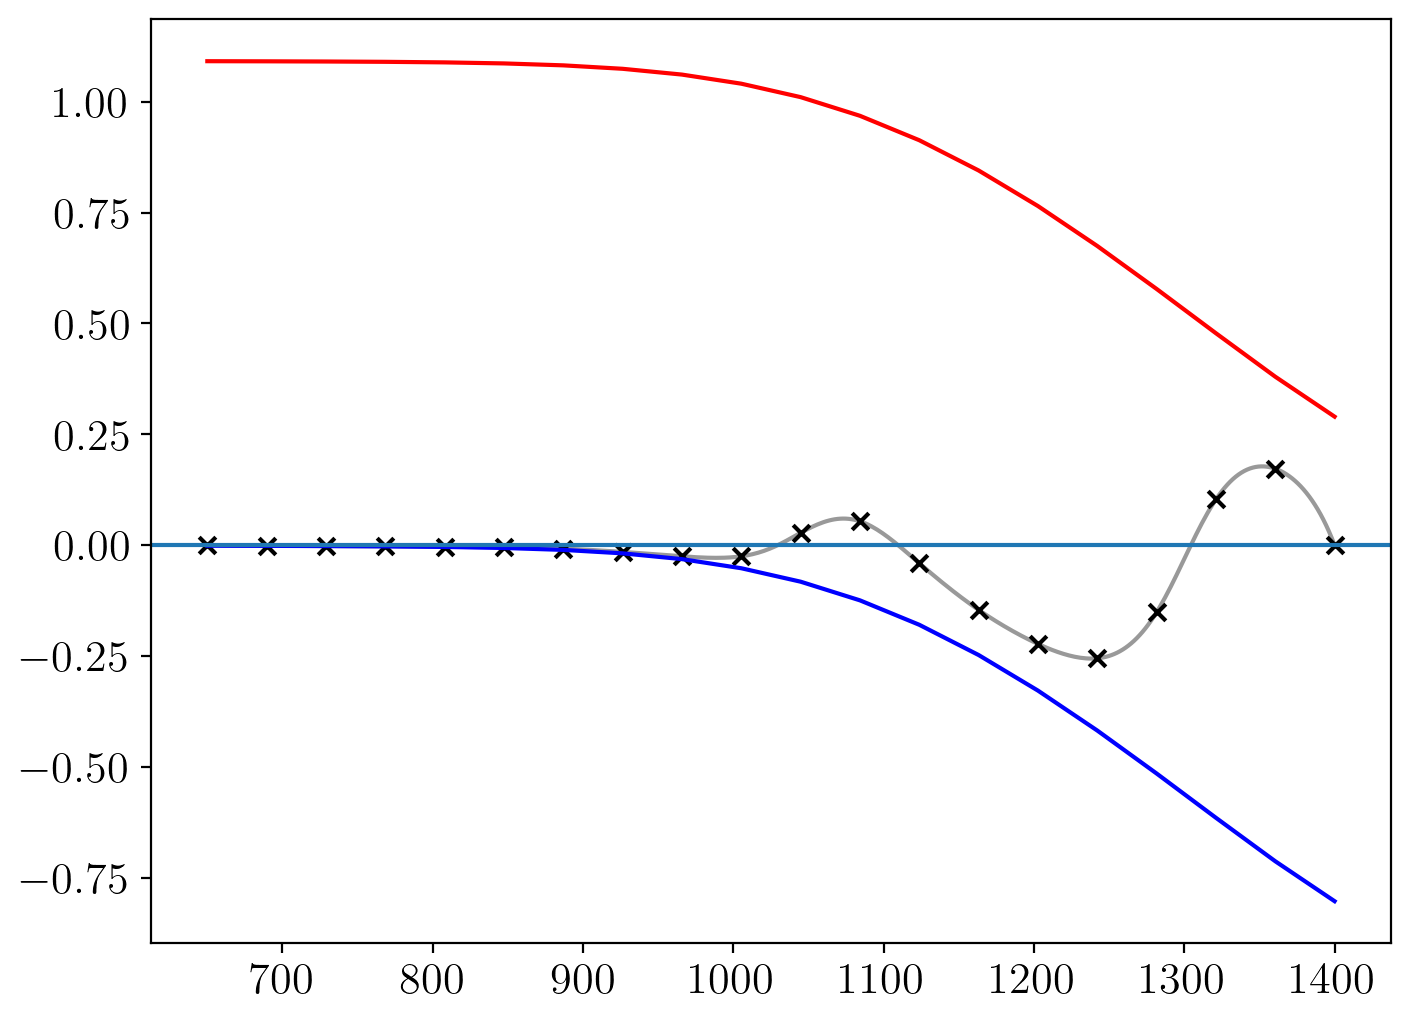

In [54]:
fig,ax = plt.subplots()

delta_xe_upper = rescale_pert_amp(100, test_points)
delta_xe_lower = rescale_pert_amp(-100, test_points)

cp_test = np.random.multivariate_normal(mean=mu, cov=sig)
print(cp_test)
z = np.linspace(zmin_pert, zmax_pert, 400)
f = scipy.interpolate.interp1d(test_points, cp_test, kind="cubic")

#for f in function_samples:
#    ax.plot(test_points, rescale_pert_amp(f, test_points), color="k", alpha=0.4)
ax.scatter(test_points, rescale_pert_amp(cp_test, test_points), marker="x", color="k")
ax.plot(z, rescale_pert_amp(f(z), z), color="k", alpha=0.4)
ax.plot(test_points, delta_xe_upper, color="red")
ax.plot(test_points, delta_xe_lower, color="blue")
ax.axhline(0.0)

plt.show()

In [30]:
print(rescale_pert_amp(9.00029459e-13, 1400))

[1.91624494e-13]
